In [2]:
import numpy as np
import pandas as pd
from os import listdir,getcwd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
zhang_dir = getcwd()+'\\ZhangData'
data = np.zeros((132,4), dtype=[('neuron_id','a13'),
                                ('raster_data',np.float32,(419,1000)),
                                ('raster_info','a20',4),
                                ('stimulus_id','a15',419),
                                ('stimulus_position','a15',419),
                                ('combined_id_position','a15',419)])

for i,data_dir in enumerate(listdir(zhang_dir)):
    raster_data, raster_info, raster_labels = [zhang_dir+'\\'+data_dir+'\\'+my_dir for my_dir in listdir(zhang_dir+'\\'+data_dir)]
    neuron_id = data_dir[0:(len(data_dir)-12)]
    data_arr = pd.read_csv(raster_data,header=None).values
    labels_arr = pd.read_csv(raster_labels,header=0).values
    if data_arr.shape == (420,1000):
        data_arr = data_arr[0:(len(data_arr)-1)]
        labels_arr = labels_arr[0:(len(labels_arr)-1)]
    data[i] = (neuron_id, data_arr, pd.read_csv(raster_info).values, labels_arr[:,0],labels_arr[:,1],labels_arr[:,2])

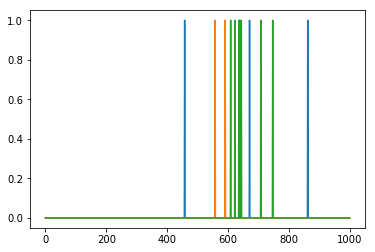

['bp1001spk_01A', 'bp1001spk_02A', 'bp1001spk_03A']

In [4]:
[x[0][0]  for x in data[['neuron_id']][0:3]]

#Get fourth run from first 3 neurons
[plt.plot(x[0][0][4]) for x in data[['raster_data']][0:3]]
plt.show()
[x[0][0] for x in data[['neuron_id']][0:3]]

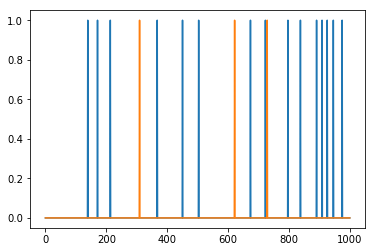

In [5]:
## for multiple neurons
y=[x['raster_data'][x[0]=='hand'] for x in data[['stimulus_id','raster_data']][:][:,0]]
plt.plot(y[0][0])
plt.plot(y[0][1])
plt.show()
#for single neurons
#[x[:,0] for x in data[['stimulus_id','raster_data']][0][0]]

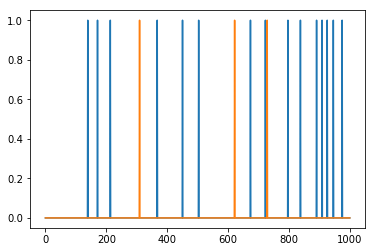

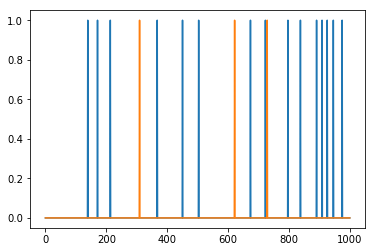

In [6]:
[plt.plot(x) for x in data['raster_data'][0][0][data['stimulus_id'][0][0]=='hand'][0:2]]
plt.show()
[plt.plot(x) for x in data['raster_data'][0][0][[0,9],:]]
plt.show()

In [7]:
def addExponentialDecayToNeuronRead(rate_of_exp_decrease, neuron_read):
    activation = 0.0
    to_return = np.zeros(len(neuron_read))
    for i,x in enumerate(neuron_read):
        if x==1.0:
            activation+=1.0
        elif ((x==0.0) and (activation>0.0)):
            activation *= rate_of_exp_decrease
        if activation<0.:
            activation=0.
        to_return[i]=activation

    return(to_return)

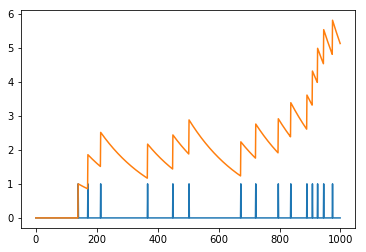

In [11]:
plt.plot(data['raster_data'][0][0][0,:])
plt.plot(addExponentialDecayToNeuronRead(0.995,data['raster_data'][0][0][0,:]))
plt.show()

In [9]:
data['raster_info'][:,0,3]

array(['1001', '1001', '1001', '1001', '1002', '1002', '1002', '1002',
       '1003', '1003', '1003', '1003', '1003', '1003', '1004', '1004',
       '1004', '1004', '1004', '1005', '1005', '1005', '1005', '1005',
       '1005', '1006', '1006', '1006', '1006', '1006', '1006', '1006',
       '1007', '1007', '1007', '1007', '1007', '1008', '1008', '1008',
       '1008', '1008', '1009', '1009', '1009', '1009', '1009', '1009',
       '1010', '1010', '1010', '1010', '1010', '1010', '1011', '1011',
       '1011', '1011', '1011', '1012', '1012', '1012', '1012', '1012',
       '1013', '1013', '1013', '1013', '1013', '1014', '1014', '1014',
       '1014', '1014', '1014', '1015', '1015', '1015', '1015', '1015',
       '1015', '1015', '1015', '1015', '1016', '1016', '1016', '1016',
       '1016', '1016', '1017', '1017', '1017', '1017', '1017', '1017',
       '1017', '1018', '1018', '1018', '1018', '1018', '1018', '1018',
       '1018', '1018', '1018', '1018', '1019', '1019', '1019', '1019',
      

In [10]:
np.unique(data['stimulus_id'][0][0])

array(['car', 'couch', 'face', 'flower', 'guitar', 'hand', 'kiwi'], 
      dtype='|S15')